In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

import numpy as np
import pandas as pd
from pydantic import BaseSettings

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn import tree

import lightgbm as lgb

import torch
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
from pytorch_tabnet.metrics import Metric
from sklearn.metrics import roc_auc_score, recall_score, precision_score
import shap
import matplotlib.pyplot as plt

In [2]:
# read the table
df = pd.read_csv("./conversion_project.csv")

# print some samples
df.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


## Data preprocessing

- 離群值如何處理？
    - 丟掉離群值？我認為不好，若是在inference phase有離群值，這樣就不好預測 (ex: 假設丟掉 age > 100的樣本，但新用戶填了超過100歲，無法對其進行預測)
    - 我的作法：修正離群值，將其調整成中位數，讓模型"盡量"不考慮這個特徵
- 遺失值如何處理？
    - tree-based model: 有些套件 (ex: Lightgbm, Xgboost)是可以將NA視為一類（在分枝時，將NA歸類到info gain較高的一邊)，在利用這種模型時，也能考慮將離群值視為na (作法不同，意義也不一樣，前者是盡量不考慮，後者是考慮為某一類)
    - 依賴數值關係的 model: 如SVM, NN,...，建議將遺失值修改成中位數或平均值，理由跟離群值一致
- 標準化
    - tree-based model: 不需要特別做標準化，因為標準化前後，數值大小之間的關係並不會改變，剪枝的過程並不會受到影響
    - 依賴數值關係的 model: 如SVM, NN,...: 連續變數建議做標準化，盡量讓每個維度的分佈接近 
- unbalence data
    - 視情況處理，如果模型train不起來，或performance不好，再對資料做 over/down sampling
    - 一般作法會採用SMOTE，但因為這組資料的連續型變數太少，不太建議這種作法

In [3]:
# 處理離群值值
df.age = df.age.replace([111, 123],  df.age.median())

In [4]:
# check null values
df.isnull().sum(axis=0)

country                0
age                    0
new_user               0
source                 0
total_pages_visited    0
converted              0
dtype: int64

In [5]:
# 類別沒有很多，所以做one-hot encoding不會讓矩陣太稀疏
country_part = pd.get_dummies(df["country"], prefix="is")
source_part = pd.get_dummies(df["source"], prefix="is")

# concat dataframes
df_oh = pd.concat([df, country_part, source_part], axis=1)

# delete original columns
del df_oh["country"], df_oh["source"]

# define features & target
features = [c for c in df_oh.columns if c != "converted"]
target = ["converted"]

# train : test = 7:3

# 資料夠多，可以切7:3
# 若資料太少，會建議切8:2, 9:1 (我認為沒有一個基準，憑感覺)
X_train, X_test, y_train, y_test = train_test_split(df_oh[features], df_oh[target], test_size=0.3, random_state=42)

In [6]:
# 建立一個confusion matrix plot
# 用於視覺化模型結果
def metrics_plot(dataset, estimator=None, prediction=None):
    # Plot non-normalized confusion matrix
    assert dataset is not None
    
    X_train, y_train, X_test, y_test = dataset
    titles_options = [
        ["Confusion matrix, Training Data", [X_train, y_train],None],
        ["Confusion matrix, Testing Data", [X_test, y_test], None],
    #     ("Normalized confusion matrix", "true"),
    ]

    if estimator:
        for title, d, normalize in titles_options:
            disp = ConfusionMatrixDisplay.from_estimator(
                estimator,
                d[0],
                d[1],
                display_labels=["Not converted", "Converted"],
                cmap=plt.cm.Blues,
                normalize=normalize,
            )
            disp.ax_.set_title(title)
        #     print(title)
        #     print(disp.confusion_matrix)
        print(classification_report(y_test, estimator.predict(X_test), target_names=["Not converted", "Converted"], digits=3))
    else:
        if not estimator:
            for i, d in enumerate(titles_options):
                titles_options[i][1][0] = prediction[i]
            for title, d, normalize in titles_options:
                disp = ConfusionMatrixDisplay.from_predictions(
                    d[1],
                    d[0],
                    display_labels=["Not converted", "Converted"],
                    cmap=plt.cm.Blues,
                    normalize=normalize,
                )
                disp.ax_.set_title(title)
            #     print(title)
            #     print(disp.confusion_matrix)
            print(classification_report(y_test, titles_options[1][1][0], target_names=["Not converted", "Converted"], digits=3))
        else:
            raise
    return

## Setting
- Loss function: Binary cross-entropy
- Metrics:
    - 考慮的準則：
        - Recall: 漏網之魚，全部有converted共有多少比例被抓出
        - Precision: 誤殺，全部預測converted的共有多少比例是真的converted
        - F1-score: Precision & Recall的調和平均
    - 不考慮的準則：
        - Accuracy: unbalanced data (如果全部猜not converted 也有97%)

               precision    recall  f1-score   support

Not converted      0.988     0.996     0.992     91848
    Converted      0.854     0.644     0.734      3012

     accuracy                          0.985     94860
    macro avg      0.921     0.820     0.863     94860
 weighted avg      0.984     0.985     0.984     94860



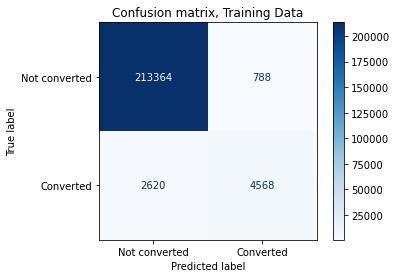

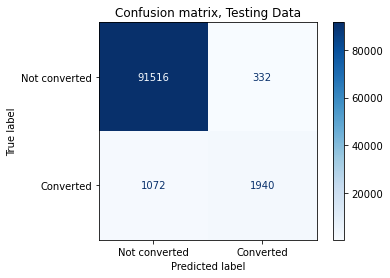

In [7]:
# Baseline: Decision Tree

clf_tree = tree.DecisionTreeClassifier(max_depth=3)
clf_tree = clf_tree.fit(X_train, y_train)
metrics_plot(dataset=(X_train, y_train, X_test, y_test), estimator=clf_tree)

- Decision Tree的結果 recall:64%, precision:85%, f1-score:73%
    - 沒有under fitting 也沒有全部偏向Not converted (Train的起來)
    - 沒有over-fitting (testing data 也有分出來)

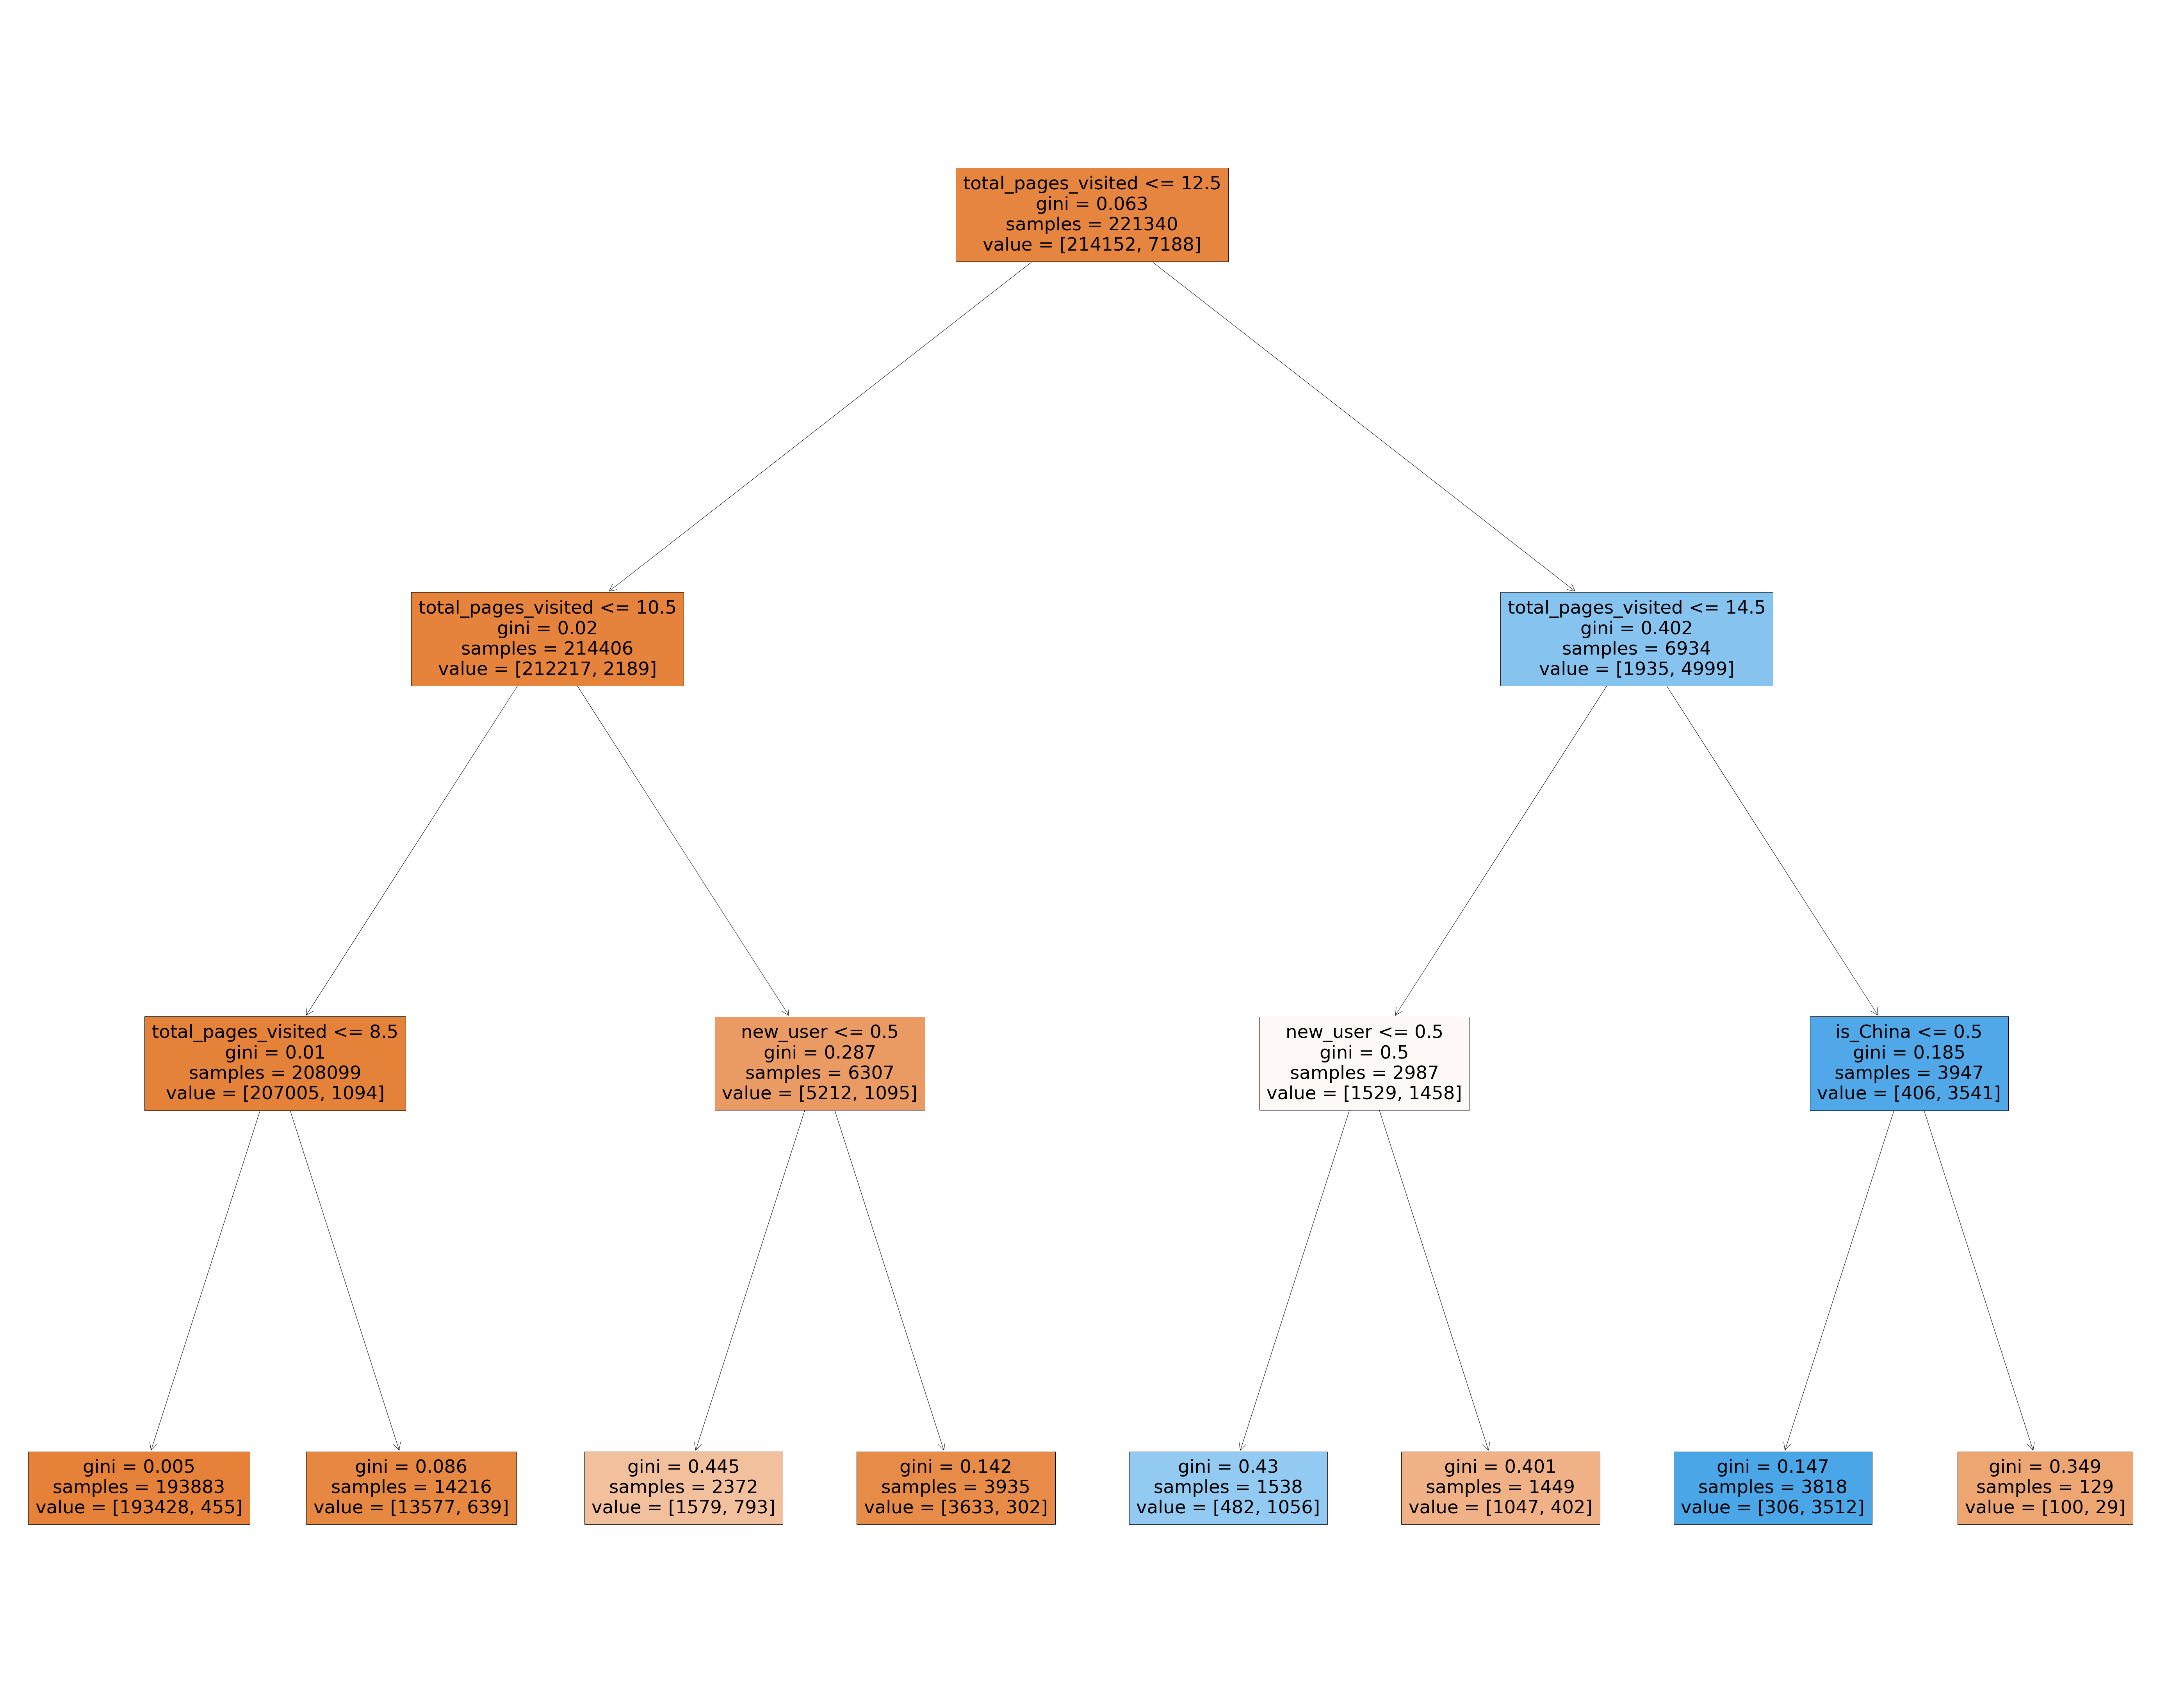

In [8]:
fig = plt.figure(figsize=(100, 80))
_ = tree.plot_tree(clf_tree
                   , feature_names=clf_tree.feature_names_in_
                   , filled=True)

- decision tree會在最後一層決定要分配給哪一個類別 (橘：Not converted, 藍：converted)
    - 可以看出有用到 total_pages_visited, new_user, is_China做區分
    - 用幾個變數就有不錯的效果

## Light GBM
- 有支援Scikit-learn API，但我自己比較習慣Training API (參數比較容易調整)
- Optimal Split for Categorical Features: https://github.com/microsoft/LightGBM/blob/master/docs/Features.rst#optimal-split-for-categorical-features
- 比較常用的模型 Lightgbm, Xgboost, Catboost比較: https://medium.com/riskified-technology/xgboost-lightgbm-or-catboost-which-boosting-algorithm-should-i-use-e7fda7bb36bc
- 為什麼我選擇LightGBM?
    - 訓練速度比較快
    - 類別變數比較好處理
    - 超參數很豐富
    - 以往經驗效果比其他兩個好

In [9]:
# Re-design the dataset for tabnet
# concat dataframes
df_le = df.copy(deep=True)
cat_features = ["country", "source"]

for idx, f in enumerate(cat_features):
    print(f"Label Encoding for: {f}")
    lb = pd.Categorical(df[f])
    map_dict = {i: c for i, c in enumerate(lb.categories)}
    print(f"Mapping: {map_dict}")
    df_le[f"{f}_lb"] = lb.codes
    cat_features[idx] = f"{f}_lb"

# # delete original columns
del df_le["country"], df_le["source"]

# define features & target
features = [c for c in df_le.columns if c != "converted"]
target = ["converted"]

# train : test = 7:3
X_train, X_test, y_train, y_test = train_test_split(df_le[features], df_le[target], test_size=0.3, random_state=42)
cat_idxs = [list(X_train.columns).index(f) for f in cat_features]
cat_dims = [X_train[f].value_counts().index.shape[0]for f in cat_features]

Label Encoding for: country
Mapping: {0: 'China', 1: 'Germany', 2: 'UK', 3: 'US'}
Label Encoding for: source
Mapping: {0: 'Ads', 1: 'Direct', 2: 'Seo'}


- 這裡使用label encoding而不是one-hot encoding的原因
    - 輸入格式：lightgbm 或 Tabnet (在下面的模型)，使用類別變數都是吃label encoding

- 我自己常用的setting
    - boosting_type: 選擇boosting tree的訓練方式
    - objective: task 目標
    - metric: training 過程中展示的結果分數
    - num_leaves: 單棵樹的葉片個數
    - learning_rate: gbdt的學習率
    - feature_fraction: 建立每一棵樹時，多少比例的特徵可以被使用
    - bagging_fraction: 每次bagging 要取出的樣本比例
    - bagging_freq: bagging的頻率
    - early_stopping_rounds: 在未來的k epoch中沒有表現比較好就停止訓練
    - num_boost_round: 最大epoch數量

In [10]:
class ModelConfigsSettings(BaseSettings):
    """Config for prediction models' parameters."""
    # specify your configurations as a dict
    lgb_params: dict = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'binary_logloss',
        'num_leaves': 63,
        'learning_rate': 0.1,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
    }
    early_stopping_rounds: int = 50
    num_boost_round: int = 1000
model_config = ModelConfigsSettings()
model_config.lgb_params["categorical_features"] = cat_idxs

In [11]:
# Scikit-learn API
gbm_sk = lgb.LGBMClassifier(
    n_estimators=model_config.num_boost_round
    , **model_config.lgb_params
)
gbm_sk.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=model_config.early_stopping_rounds)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[1]	valid_0's binary_logloss: 0.0848252
Training until validation scores don't improve for 50 rounds
[2]	valid_0's binary_logloss: 0.0780315
[3]	valid_0's binary_logloss: 0.0727495
[4]	valid_0's binary_logloss: 0.0684673
[5]	valid_0's binary_logloss: 0.0649111
[6]	valid_0's binary_logloss: 0.0618755
[7]	valid_0's binary_logloss: 0.0592895
[8]	valid_0's binary_logloss: 0.0570788
[9]	valid_0's binary_logloss: 0.0551298
[10]	valid_0's binary_logloss: 0.0534478
[11]	valid_0's binary_logloss: 0.0519684
[12]	valid_0's binary_logloss: 0.0506695
[13]	valid_0's binary_logloss: 0.0495371
[14]	

LGBMClassifier(bagging_fraction=0.8, bagging_freq=5,
               categorical_features=[3, 4], feature_fraction=0.9,
               metric='binary_logloss', n_estimators=1000, num_leaves=63,
               objective='binary')

               precision    recall  f1-score   support

Not converted      0.990     0.996     0.993     91848
    Converted      0.842     0.693     0.760      3012

     accuracy                          0.986     94860
    macro avg      0.916     0.844     0.877     94860
 weighted avg      0.985     0.986     0.985     94860



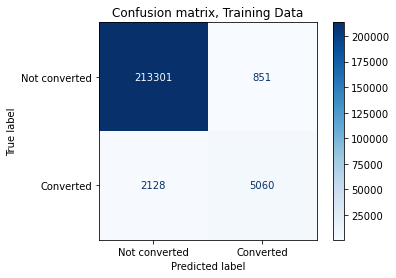

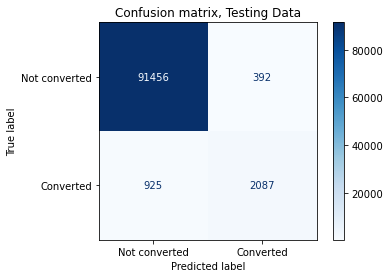

In [12]:
metrics_plot(dataset=(X_train, y_train, X_test, y_test), estimator=gbm_sk)

In [13]:
# create lgb dataset
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(
    X_test, y_test, reference=lgb_train)
evals_result = {}

gbm_or = lgb.train(model_config.lgb_params,
                                lgb_train,
                                num_boost_round=model_config.num_boost_round,
                                valid_sets=lgb_eval, early_stopping_rounds=model_config.early_stopping_rounds,
#                                 callbacks=[
#                                     lgb.record_evaluation(evals_result)
#                                 ]
                )

[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Info] Number of positive: 7188, number of negative: 214152
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001408 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 94
[LightGBM] [Info] Number of data points in the train set: 221340, number of used features: 5
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.032475 -> initscore=-3.394273
[LightGBM] [Info] Start training from score -3.394273
[1]	valid_0's binary_logloss: 0.0848252
Training until validation scores don't improve for 50 rounds
[2]	valid_0's binary_logloss: 0.0780315
[3]	valid_0's binary_logloss: 0.0727495
[4]	valid_0's binary_logloss: 0.0684673
[5]	valid_0's binary_logloss: 0.06491

               precision    recall  f1-score   support

Not converted      0.990     0.996     0.993     91848
    Converted      0.842     0.693     0.760      3012

     accuracy                          0.986     94860
    macro avg      0.916     0.844     0.877     94860
 weighted avg      0.985     0.986     0.985     94860



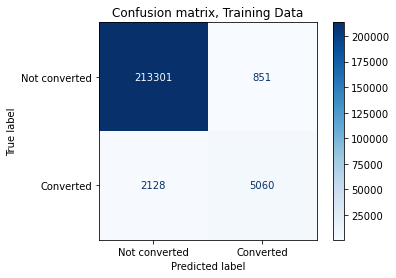

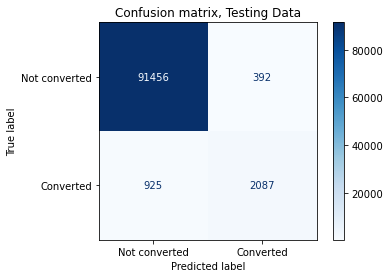

In [14]:
y_pred_train = np.round(gbm_or.predict(X_train), decimals=0)
y_pred_test = np.round(gbm_or.predict(X_test), decimals=0)

metrics_plot(dataset=(X_train, y_train, X_test, y_test), prediction=(y_pred_train, y_pred_test))

- LightGBM 的結果 recall:68% (64% -> 68%), precision:84% (85% -> 84%), f1-score:75% (73% -> 75%)
    - Recall, F1都有提升，Precision略降

Plotting feature importances...


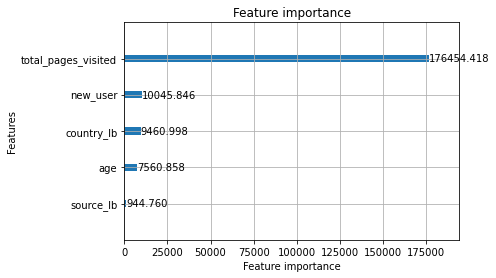

In [15]:
print('Plotting feature importances...')
ax = lgb.plot_importance(gbm_or, importance_type="gain")
plt.show()

- 觀察重要變數 (post-hoc importance)
    - importance_type: "gain" (If “gain”, result contains total gains of splits which use the feature.)
    - 可以看到total_pages_visited幾乎支配了整個模型
    - new_user也貢獻很多

<AxesSubplot:>

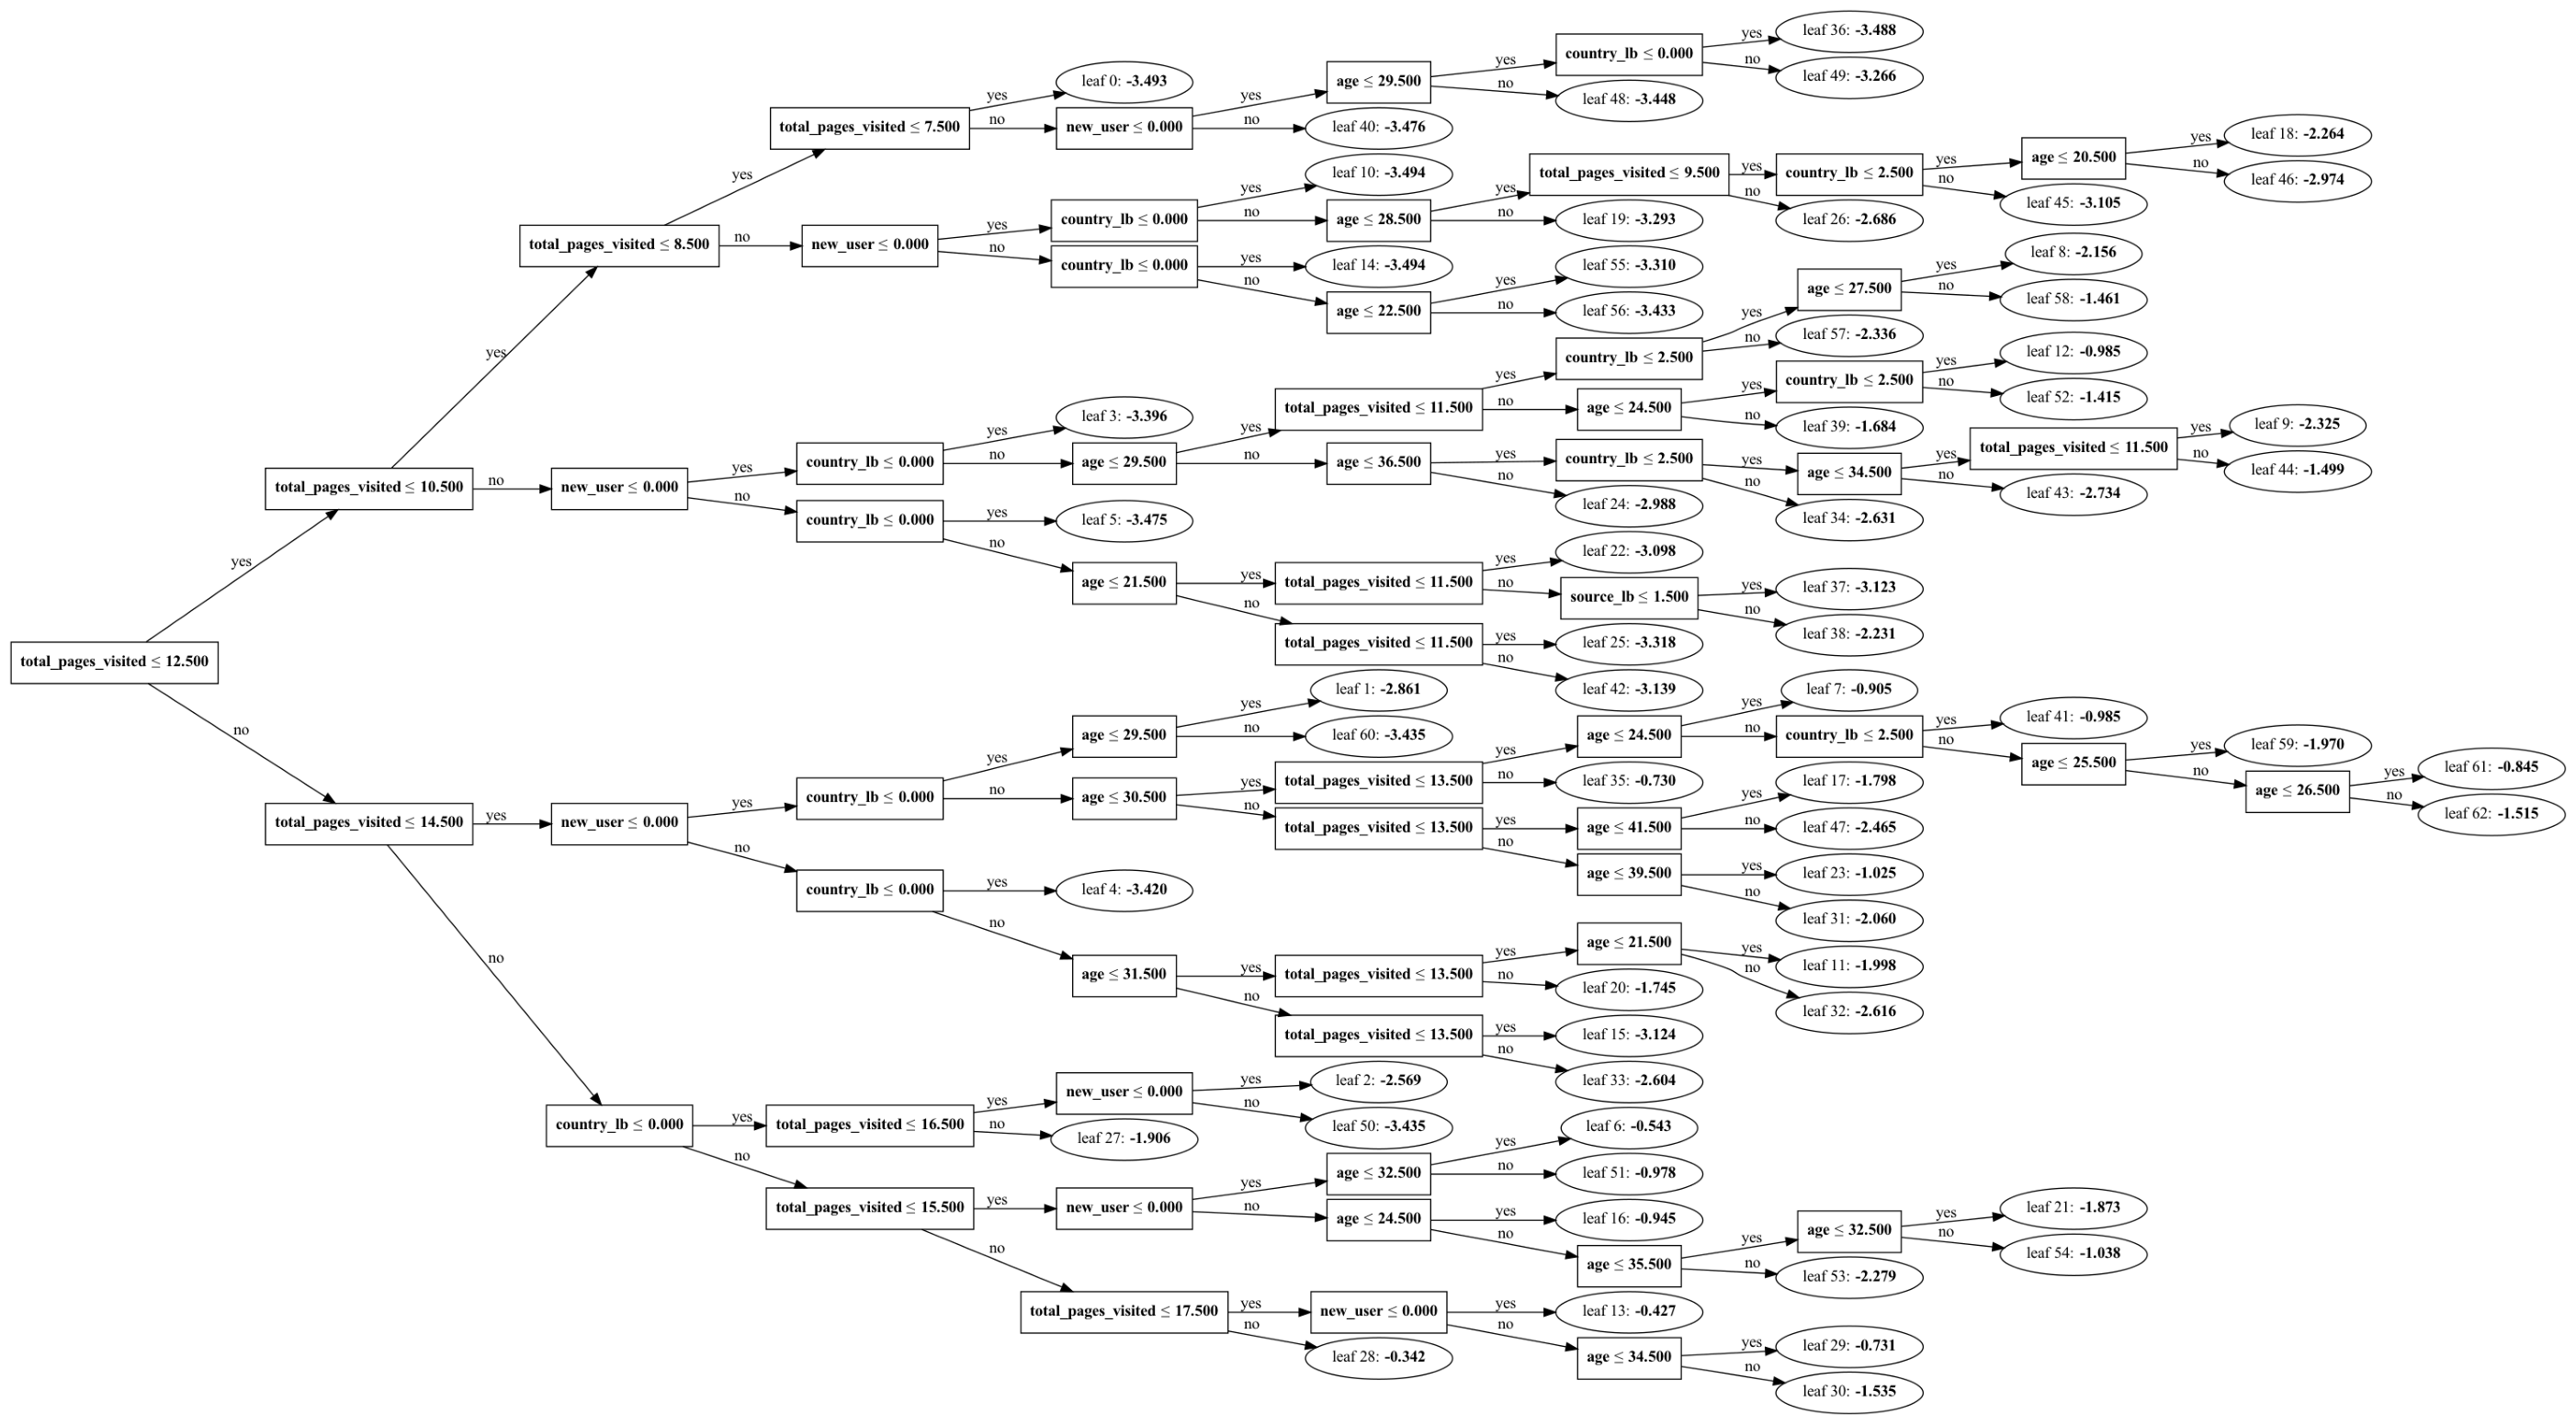

In [20]:
fig, ax = plt.subplots(figsize=(50, 40))
lgb.plot_tree(gbm_or, ax=ax, tree_index=0)

- GBDT 可以看第一棵樹（後面的樹只是fit殘差，重要度比較沒那麼高）
    - 深度、葉子、使用特徵都有明顯變多 (參考更多指標)
    - total_pages_visited使用次數明顯較高

## Shap

In [37]:
explainer = shap.Explainer(gbm_or, X_train)
shap_values = explainer(X_train)

100%|===================| 221253/221340 [03:21<00:00]        

- WatetFall
    - Shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the model output

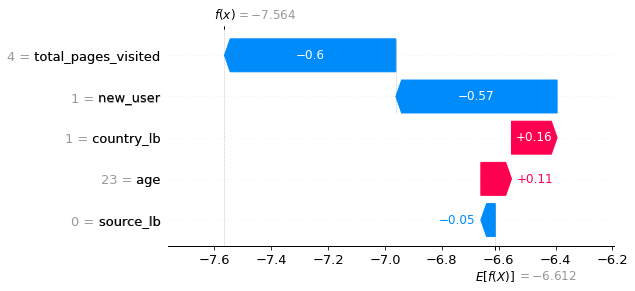

In [38]:
shap.plots.waterfall(shap_values[0])

- Beeswarm
    - summarize the effects of all the features

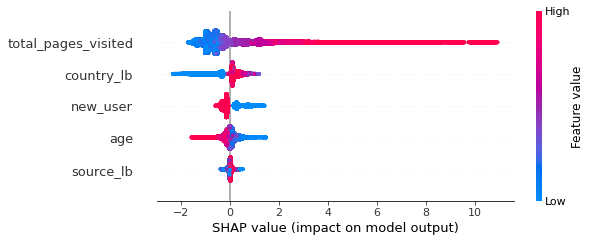

In [39]:
shap.plots.beeswarm(shap_values)

- Histogram
    - mean absolute value of the SHAP values for each feature

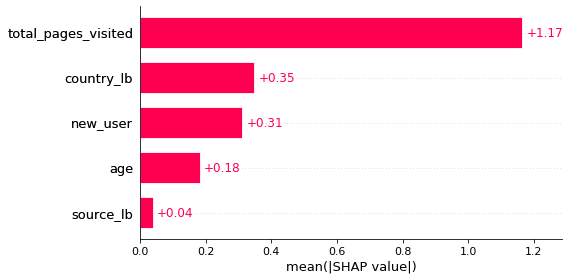

In [40]:
fig, ax = plt.subplots(1, figsize=(10, 5))
shap.plots.bar(shap_values, max_display=20, show=False)
ax.figure.tight_layout()
fig.savefig("decision.png")

## TabNet
- TabNet介紹：https://docs.google.com/presentation/d/1VvrQcQS1Q5AEgtGtW6zj0F7_kF0T6f8u/edit#slide=id.g1541dc7cbea_0_335

In [18]:
# metrics definition
class Gini(Metric):
    def __init__(self):
        self._name = "gini"
        self._maximize = True

    def __call__(self, y_true, y_score):
        auc = roc_auc_score(y_true, y_score[:, 1])
        return max(2*auc - 1, 0.)
    
class Recall(Metric):
    """
    Accuracy.
    """

    def __init__(self):
        self._name = "recall"
        self._maximize = True

    def __call__(self, y_true, y_score):
        """
        Compute recall of predictions.
        Parameters
        ----------
        y_true: np.ndarray
            Target matrix or vector
        y_score: np.ndarray
            Score matrix or vector
        Returns
        -------
        float
            recall of predictions vs targets.
        """
        y_pred = np.argmax(y_score, axis=1)
        return recall_score(y_true, y_pred)
    
class Precision(Metric):
    """
    Accuracy.
    """

    def __init__(self):
        self._name = "precision"
        self._maximize = True

    def __call__(self, y_true, y_score):
        """
        Compute precision of predictions.
        Parameters
        ----------
        y_true: np.ndarray
            Target matrix or vector
        y_score: np.ndarray
            Score matrix or vector
        Returns
        -------
        float
            precision of predictions vs targets.
        """
        y_pred = np.argmax(y_score, axis=1)
        return precision_score(y_true, y_pred)

- 定義metics: 主要使用Gini, Recall, Precision來觀察模型表現
    - 使用gini (auc相關) 當成early stopping的準則

In [20]:
# Re-design the dataset for tabnet
# concat dataframes
df_le = df.copy(deep=True)
cat_features = ["country", "source"]

for idx, f in enumerate(cat_features):
    print(f"Label Encoding for: {f}")
    lb = pd.Categorical(df[f])
    map_dict = {i: c for i, c in enumerate(lb.categories)}
    print(f"Mapping: {map_dict}")
    df_le[f"{f}_lb"] = lb.codes
    cat_features[idx] = f"{f}_lb"

# # delete original columns
del df_le["country"], df_le["source"]

# define features & target
features = [c for c in df_le.columns if c != "converted"]
target = ["converted"]

# train : test = 7:3
X_train, X_test, y_train, y_test = train_test_split(df_le[features], df_le[target], test_size=0.3, random_state=42)
cat_idxs = [list(X_train.columns).index(f) for f in cat_features]
cat_dims = [X_train[f].value_counts().index.shape[0]for f in cat_features]

Label Encoding for: country
Mapping: {0: 'China', 1: 'Germany', 2: 'UK', 3: 'US'}
Label Encoding for: source
Mapping: {0: 'Ads', 1: 'Direct', 2: 'Seo'}


- 前處理，作法同lightgbm的處理方式

In [21]:
tabnet_estimator = TabNetClassifier(
    cat_idxs=cat_idxs,
    cat_dims=cat_dims,
)
tabnet_estimator.fit(
    X_train=X_train.values, y_train=np.reshape(np.array(y_train), (-1)),
    eval_set=[(X_train.values, np.reshape(np.array(y_train), (-1)))
              , (X_test.values, np.reshape(np.array(y_test), (-1)))],
    eval_name=['train', 'valid'],
    eval_metric=["auc", "recall", "precision", "gini"],
    batch_size=16384, virtual_batch_size=256,
)

Device used : cuda
epoch 0  | loss: 0.11608 | train_auc: 0.86634 | train_recall: 0.29647 | train_precision: 0.54571 | train_gini: 0.73268 | valid_auc: 0.86212 | valid_recall: 0.29548 | valid_precision: 0.52663 | valid_gini: 0.72423 |  0:00:07s
epoch 1  | loss: 0.05453 | train_auc: 0.88825 | train_recall: 0.52713 | train_precision: 0.12079 | train_gini: 0.77651 | valid_auc: 0.88735 | valid_recall: 0.52922 | valid_precision: 0.11828 | valid_gini: 0.7747  |  0:00:14s
epoch 2  | loss: 0.04849 | train_auc: 0.9076  | train_recall: 0.5569  | train_precision: 0.16602 | train_gini: 0.8152  | valid_auc: 0.90742 | valid_recall: 0.55312 | valid_precision: 0.1612  | valid_gini: 0.81483 |  0:00:22s
epoch 3  | loss: 0.04639 | train_auc: 0.95878 | train_recall: 0.81733 | train_precision: 0.29643 | train_gini: 0.91756 | valid_auc: 0.96056 | valid_recall: 0.82902 | valid_precision: 0.29484 | valid_gini: 0.92111 |  0:00:29s
epoch 4  | loss: 0.04432 | train_auc: 0.97089 | train_recall: 0.85768 | train_pre

               precision    recall  f1-score   support

Not converted      0.990     0.996     0.993     91848
    Converted      0.849     0.687     0.759      3012

     accuracy                          0.986     94860
    macro avg      0.920     0.841     0.876     94860
 weighted avg      0.985     0.986     0.985     94860



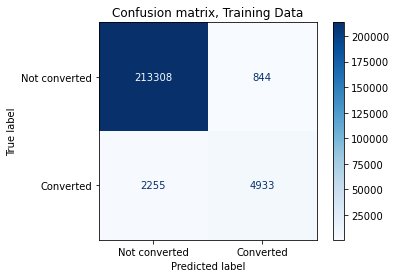

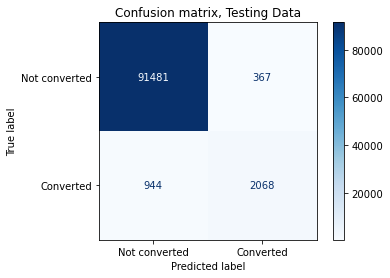

In [22]:
y_pred_train = tabnet_estimator.predict(X_train.values)
y_pred_test = tabnet_estimator.predict(X_test.values)

metrics_plot(dataset=(X_train, y_train, X_test, y_test), prediction=(y_pred_train, y_pred_test))

- TabNet 的結果 recall:68% (64% -> 68%), precision:84% (85% -> 84%), f1-score:75% (73% -> 75%)
    - Recall, F1都有提升，Precision略降
    - 跟Lightgbm表現差不多

### Encoder Visualization
- TabNet優勢：Instance-wise interpretability，可以觀察每一筆樣本在模型每個階段的重要程度

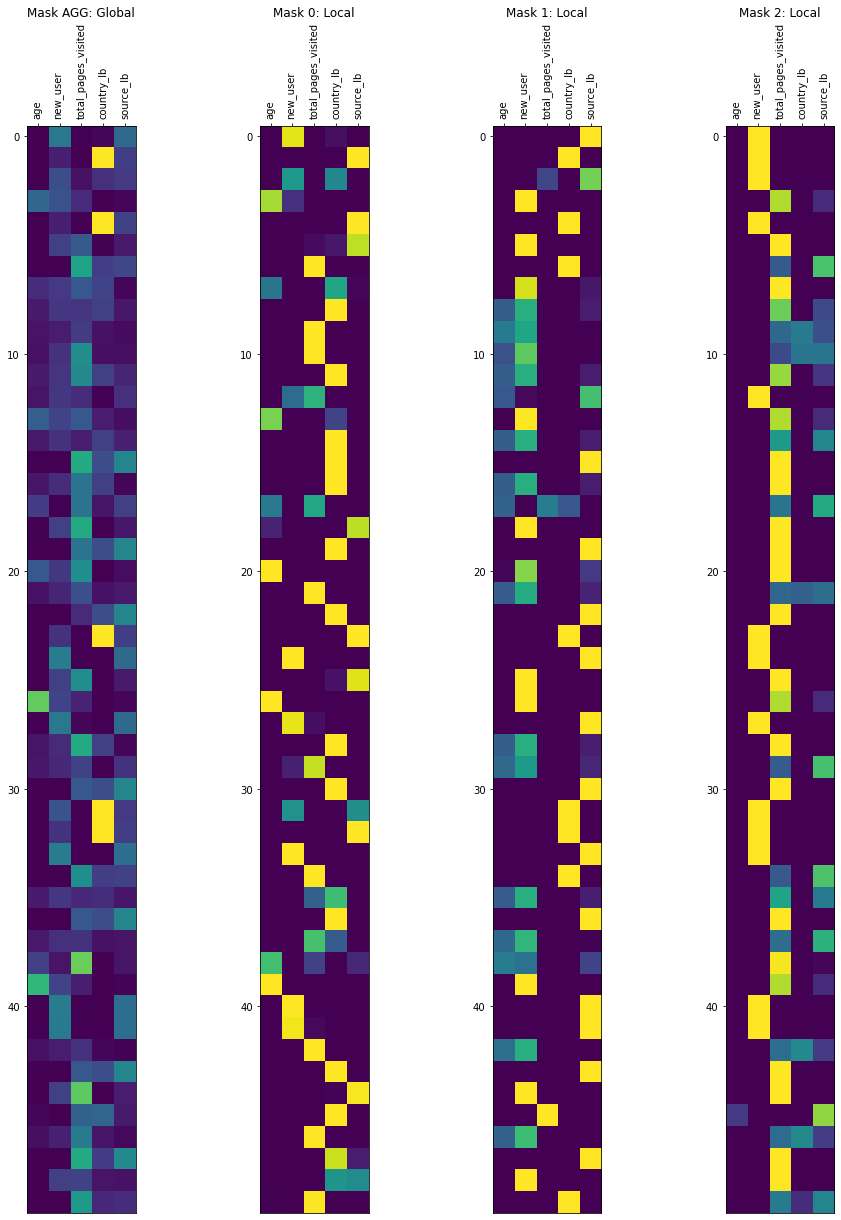

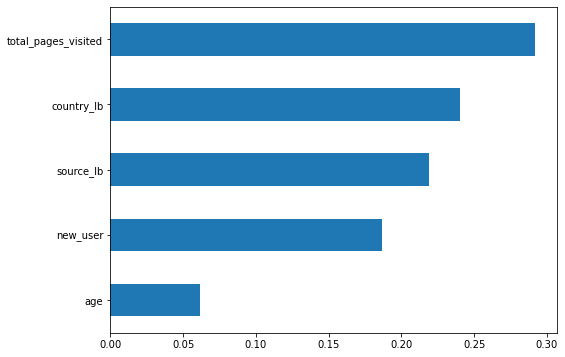

In [29]:
import matplotlib.pyplot as plt
plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True
supervised_explain_matrix, supervised_masks = tabnet_estimator.explain(X_train.values)

fig, axs = plt.subplots(1, len(supervised_masks.keys())+1, figsize=(16,20))

axs[0].imshow(pd.DataFrame(supervised_explain_matrix[:50], columns=X_train.columns))
axs[0].set_xticks(range(len(X_train.columns)), X_train.columns)
axs[0].set_xticklabels(X_train.columns, rotation=90)
axs[0].set_title("Mask AGG: Global")
                        
for i in range(len(supervised_masks.keys())):
    axs[i+1].imshow(pd.DataFrame(supervised_masks[i][:50], columns=X_train.columns))
    axs[i+1].set_xticks(range(len(X_train.columns)), X_train.columns)
    axs[i+1].set_xticklabels(X_train.columns, rotation=90)
    axs[i+1].set_title(f"Mask {i}: Local")
fig.savefig("./tabnet_interpretability.jpg")

plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = True
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = False
fig, ax = plt.subplots(1, 1, figsize=(8,6))
pd.DataFrame([tabnet_estimator.feature_importances_], columns=X_train.columns
            ).T.sort_values(by=0, ascending=True).plot.barh(ax=ax, figsize=(8, 6), legend=False)
fig.savefig("./tabnet_importance.jpg")

Instance-wise interpretability
- Global: 可以視為整體而言，最看重哪個特徵
    - Mask i: 在模型的每一層中，特徵貢獻度
    - Mask 2 結果比較明確，主要看total_pages_visited, new_user
- Feature importance: 主要看total_pages_visited 貢獻度較大，但其他的也都有一定貢獻

### T-SNE Visualization
- http://speech.ee.ntu.edu.tw/~tlkagk/courses/ML_2017/Lecture/TSNE.pdf

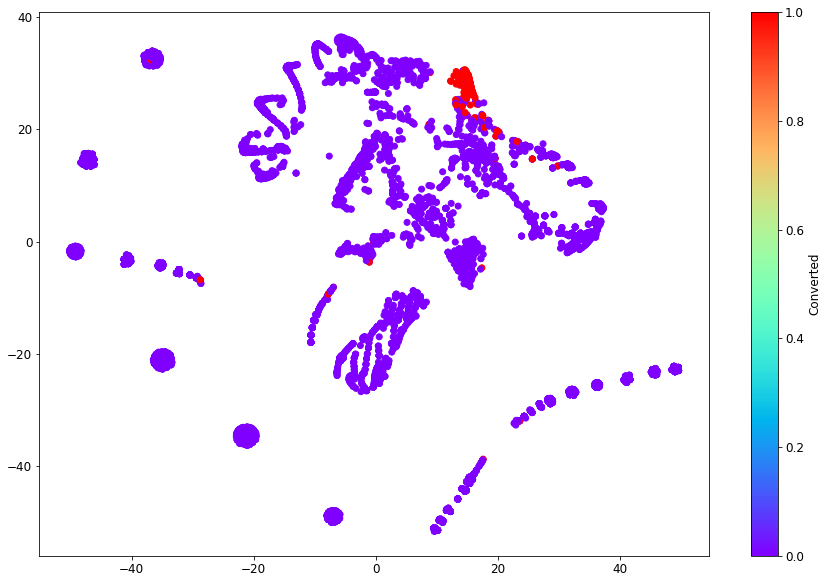

In [25]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

viz_data = X_train.iloc[:5000, :]
viz_data_y = y_train.iloc[:5000, :]

steps_output, M_loss = tabnet_estimator.network.tabnet.encoder(
    torch.tensor(viz_data.values.astype(np.float32)).to(tabnet_estimator.device).float()
    )
X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=100, random_state=42
                 ).fit_transform((torch.sum(torch.stack(steps_output, dim=0), dim=0)
                                 ).cpu().detach().numpy()[:, :8])

plt.rc('font', size=12)
fig, ax = plt.subplots(1, figsize=(15, 10))
im = ax.scatter(X_embedded[:, 0], X_embedded[:, 1], c=viz_data_y.values
                , cmap=plt.cm.rainbow)

cb = fig.colorbar(im)
cb.set_label('Converted')

- 對TabNet的每層輸出加總做T-SNE (降維視覺化)
    - 由於樣本數太大，只取5000個做視覺化
    - 分的結果蠻不錯的 (Converted 大部分都有落在同一區)

### Discussion
- Recall or Precision?
    - 商業層面考量，我認為Recall會比較重要，更需要捕捉大部分會有交易行為的用戶，如果要進行決策：
        - 因為他們是能夠實際轉換＄的用戶，對他們進行推薦會更有利
- 如何提升conversion rate？
    - 目前的轉換率約為3%
    - US, UK是可以考慮進行主動推薦的用戶 (China用戶雖高，但轉換率極低，可以不用當成主要對象)
    - 透過Ads管道的用戶相較而言轉換率較高，可以對Ads投入更多資源
    - 年紀20~30歲的轉換率較高，可以從這個年齡層下手
    - 對那些Not converted做特別推薦，挽留 or 特殊優惠
- Prediction
    - 我認為這個task要做的更好，需要考慮以下幾點
        - 想做特徵工程但做不了：特徵數過少
        - 需要加入更多歷史資訊的特徵，有id對應會更好（現在的instance有可能對到同一個人，若是同一個人，可以得到更多特徵），日期(月份、季節、假日)、是否有進行促銷（商品、活動）等等的特徵可以考慮。
        - Trigger時機困惑，什麼時候要觸發Prediction? 有收集到total_pages_visited這個特徵，表示已經結束整個消費旅程，是他每翻一頁就觸發一次，還是在他下一次旅程開始時進行推薦(也需要知道哪個id)，但就會與task有drift
    - Model表現：以Recall當準則：LightGBM = TabNet > Decision Tree
        - LightGBM, TabNet 可以提供更多決策資訊（提出特徵重要）
    - Importance:
        - TabNet, Shap 可以看到每個instance的表現，更可以客製化的進行推薦
        - Post-hoc importance，整體而言Lightgbm, Shap, Tabnet提出的結論很接近
            - total_pages_visited, new_user, country都對模型有很好的貢獻
            - Tabnet對於source使用的更多

## Reference
- Decision Tree
    - pkg: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
- TSNE:
    - Intro: http://speech.ee.ntu.edu.tw/~tlkagk/courses/ML_2017/Lecture/TSNE.pdf
    - pkg: - https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
    - paper: https://proceedings.neurips.cc/paper/2017/file/6449f44a102fde848669bdd9eb6b76fa-Paper.pdf
- LightGBM:
    - pkg: https://github.com/microsoft/LightGBM
    - docs: https://lightgbm.readthedocs.io/en/v3.3.2/Python-API.html
    - parameters: https://github.com/Microsoft/LightGBM/blob/master/docs/Parameters.rst
    - lgb, xgb, cat: https://medium.com/riskified-technology/xgboost-lightgbm-or-catboost-which-boosting-algorithm-should-i-use-e7fda7bb36bc
- TabNet:
    - Intro: https://docs.google.com/presentation/d/1VvrQcQS1Q5AEgtGtW6zj0F7_kF0T6f8u/edit#slide=id.g1541dc7cbea_0_335
    - pkg: https://github.com/dreamquark-ai/tabnet
    - paper: https://arxiv.org/abs/1908.07442
- Shap:
    - paper: https://github.com/slundberg/shap
    - pkg: https://proceedings.neurips.cc/paper/2017/file/8a20a8621978632d76c43dfd28b67767-Paper.pdf